<a id='begin'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Stroke Prediction 💊 </p>

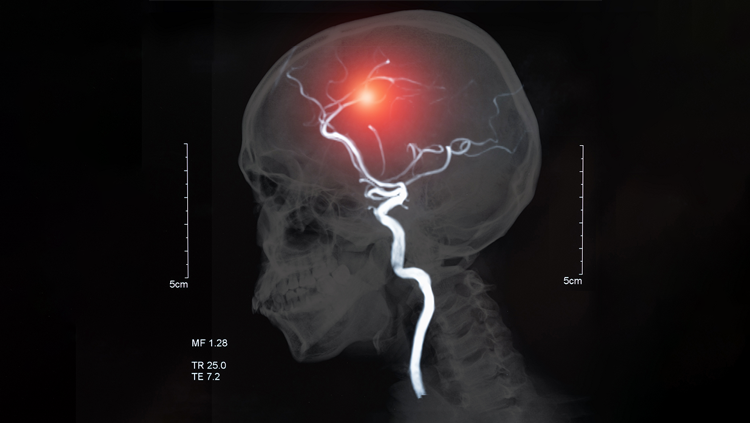

 A stroke is a medical condition in which poor blood flow to the brain causes cell death. There are two main types of stroke: ischemic, due to lack of blood flow, and hemorrhagic, due to bleeding. Both cause parts of the brain to stop functioning properly.

 The main risk factor for stroke is **high blood pressure.** Other risk factors include **tobacco smoking**, **obesity**, **high blood cholesterol**, **diabetes mellitus**, **a previous TIA**, **end-stage kidney disease**, **and atrial fibrillation**.

In [ ]:
#Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,roc_auc_score,plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



<a id='loaddata'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">Loading data 📂 </p>

In [ ]:
# Loading Dataset

df = pd.read_csv(r"/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head(10)

<a id='begin'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Explotorary Data Analysis 📈 </p>

In [ ]:
#Data shape and column names.

print(
    f'Dataset has {df.shape[1]} features, {df.shape[0]} observations.\nDataset features are:\n{df.columns.tolist()}\n'
)

In [ ]:
df.info()

In [ ]:
#Information about numerical features.

df.describe()

In [ ]:
#Checking missing values.

df.isnull().sum()


**We have 201 missing value in BMI column.  We have to fill the missing values.**

In [ ]:
#Unique values in each columns.

df.nunique()


In [ ]:
df["gender"].value_counts()

* We have 3 values for gender. We 'll replace Other value with the value with most repetative one which is female.

In [ ]:
# Replacing other value with female
df["gender"] = df["gender"].replace(['Other'],'Female')


In [ ]:
#Filling missing values with mean of BMI

df['bmi'].fillna(int(df['bmi'].mean()), inplace=True)

In [ ]:
df["work_type"].value_counts()


**Lets check the people who never worked**

In [ ]:
df[df["work_type"] == "Never_worked"]

**By looking age column we can add this to children.**

In [ ]:
# Replacing never_worked value with children
df["work_type"] = df["work_type"].replace(['Never_worked'],'children')

In [ ]:
categorical = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status","stroke"]
numerical = ["age","avg_glucose_level","bmi"]

<a id='id'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 10px 35px;">Feature Distributions 📊 </p>

In [ ]:

plt.figure(figsize=(15,30))
for i in enumerate(categorical):
    plt.subplot(4,2,i[0]+1)
    sns.countplot(x = i[1],
                  data = df ,
                  order = df[i[1]].value_counts().index,
                  palette="muted")
    
    plt.title(i[1] +' distribution')
    
    

* Dataset contains more female.
* Residence type distribution is balanced.
* Target feature is stroke which is imbalanced.


In [ ]:
f, axes = plt.subplots(3, 2, figsize=(14,8))
sns.histplot( x=df.age , ax=axes[0,0])
axes[0,0].set_title("Age Distribution")
sns.boxplot( x=df.age , ax=axes[0,1])
axes[0,1].set_title("Boxplot of Age")
sns.histplot(x=df.avg_glucose_level , ax=axes[1,0])
axes[1,0].set_title("Average Glucose Level Distribution")
sns.boxplot(x=df.avg_glucose_level, ax= axes[1,1])
axes[1,1].set_title("Boxplot of Average Glucose Level")
sns.histplot(x=df.bmi,ax=axes[2,0])
axes[2,0].set_title("BMI Distribution")
sns.boxplot(x=df.bmi, ax = axes[2,1])
axes[2,1].set_title("Boxplot of BMI")
plt.tight_layout()

**We can see that, there are many outliers in column of Average Glucose Level and BMI. We have to deal with them in modelling phase.**

In [ ]:

plt.figure(figsize=(15,30))

for i in enumerate(categorical[:-1]):
    plt.subplot(4,2,i[0]+1)
    sns.countplot(x = i[1],
                  data = df ,
                  hue = "stroke",
                  order = df[i[1]].value_counts().index,
                  palette="muted")
    
    plt.title(i[1] +' distribution')
    
   

* Hard to interpret the graphs because of imbalanced dataset.

<a id='id'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 10px 35px;">Feature Engineering ✂️</p>

In [ ]:
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)

In [ ]:
drop_outliers(df,"avg_glucose_level")

In [ ]:
drop_outliers(df,"bmi")

**We remove the outliers in columns of avg_glucose_level and bmi**

In [ ]:
df['gender'] = df['gender'].replace({'Male':1,'Female':0})

df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})

df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':3})

df['ever_married'] = df['ever_married'].replace({'Yes':1,'No':0})

df['Residence_type'] = df['Residence_type'].replace({'Urban':1,'Rural':0})

df['smoking_status'] = df['smoking_status'].replace({'never smoked':0,'Unknown':1,'formerly smoked':2,'smokes':3})

In [ ]:
df.drop("id",axis=1,inplace=True)

In [ ]:
df["stroke"].value_counts()

In [ ]:
X = df.drop('stroke', axis=1)
y = df['stroke']

<a id='id'></a>
# <p style="background-color:white; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 10px 35px;">Modelling 📏</p>

In [ ]:
from imblearn.over_sampling import SMOTE


**SMOTE (Synthetic Minority Oversampling Technique) – Oversampling**

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
It aims to balance class distribution by randomly increasing minority class examples by replicating them.

In [ ]:
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X, y.ravel())


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_os[numerical] = scaler.fit_transform(X_os[numerical])

In [ ]:
cv = KFold(10, shuffle=True,random_state=42)

In [ ]:
LReg = cross_validate(
            LogisticRegression(),
            X_os,
            y_os,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True
            )

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

In [ ]:
DTC = cross_validate(
            DecisionTreeClassifier(),
            X_os,
            y_os,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True
            )

  Decision Tree algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems too.

In [ ]:
RFC = cross_validate(
            RandomForestClassifier(),
            X_os,
            y_os,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True
            )

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [ ]:
SVC = cross_validate(
            SVC(),
            X_os,
            y_os,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True
            )

Support-vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.


In [ ]:
XGB = cross_validate(
            XGBClassifier(use_label_encoder =False),
            X_os,
            y_os,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True
            )

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) 

In [ ]:
modelstats =  {'Model':['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'SVC','XGB Classifier'],
        'Train Accuracy Mean': [LReg['train_accuracy'].mean(),DTC['train_accuracy'].mean(),RFC['train_accuracy'].mean(),SVC['train_accuracy'].mean(),XGB['train_accuracy'].mean()],
        'Test Accuracy Mean':[LReg['test_accuracy'].mean(),DTC['test_accuracy'].mean(),RFC['test_accuracy'].mean(),SVC['test_accuracy'].mean(),XGB['test_accuracy'].mean()],
        'Train f1':[LReg['train_f1'].mean(),DTC['train_f1'].mean(),RFC['train_f1'].mean(),SVC['train_f1'].mean(),XGB['train_f1'].mean()],
        'Test f1' :[LReg['test_f1'].mean(),DTC['test_f1'].mean(),RFC['test_f1'].mean(),SVC['test_f1'].mean(),XGB['test_f1'].mean()],
        'Train ROC-AUC':[LReg['train_roc_auc'].mean(),DTC['train_roc_auc'].mean(),RFC['train_roc_auc'].mean(),SVC['train_roc_auc'].mean(),XGB['train_roc_auc'].mean()],
        'Test ROC-AUC':[LReg['test_roc_auc'].mean(),DTC['test_roc_auc'].mean(),RFC['test_roc_auc'].mean(),SVC['test_roc_auc'].mean(),XGB['test_roc_auc'].mean()]      
     }  

In [ ]:
modeltable = pd.DataFrame(modelstats) 
modeltable

* Decision tree based models overfitted.

* I should try hyperparameter tuning for models.



Thank you for checking my work. I' m  trying to learn .Thanks for all the recommendations. Have a wonderful day.